In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

In [22]:
# Set global plot settings
matplotlib.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14
})

In [23]:
# Load dataset
data = pd.read_csv("synthetic_data.csv")  # Change filename as needed
data
print("Shape of the dataset:", data.shape)
print("\nMissing values:\n", data.isnull().sum())

Shape of the dataset: (2000, 10)

Missing values:
 Date                  0
Shown                 0
Clicked               0
Converted             0
Avg_cost_per_click    0
Total_revenue         0
Ad_group              0
Region                0
Device_type           0
CTR                   0
dtype: int64


In [24]:
# Convert 'date' column
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], format="%d/%m/%Y", errors='coerce')
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data.drop('date', axis=1, inplace=True)

In [25]:
# Encode categorical features
for col in data.select_dtypes(include='object').columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [26]:
# Fix any potential NaN rows
data.dropna(inplace=True)

In [27]:
# Ensure target column exists
assert 'Total_revenue' in data.columns or 'total_revenue' in data.columns, "Target column not found!"

In [28]:
# Normalize column name
if 'Total_revenue' in data.columns:
    data.rename(columns={'Total_revenue': 'total_revenue'}, inplace=True)

In [29]:
# Define features and target
y = data['total_revenue']
X = data.drop('total_revenue', axis=1)

In [30]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [31]:
# Train XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [32]:
# Make predictions
y_pred = model.predict(X_test)

In [33]:
# Evaluation Metrics
print(f"\nMean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")


Mean Squared Error: 71436.5433
Mean Absolute Error: 221.5079
R² Score: -0.3491


In [34]:
# Evaluation
print("\n--- Evaluation Metrics ---")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


--- Evaluation Metrics ---
Mean Squared Error: 71436.54
Mean Absolute Error: 221.51
R² Score: -0.35


<Figure size 1200x600 with 0 Axes>

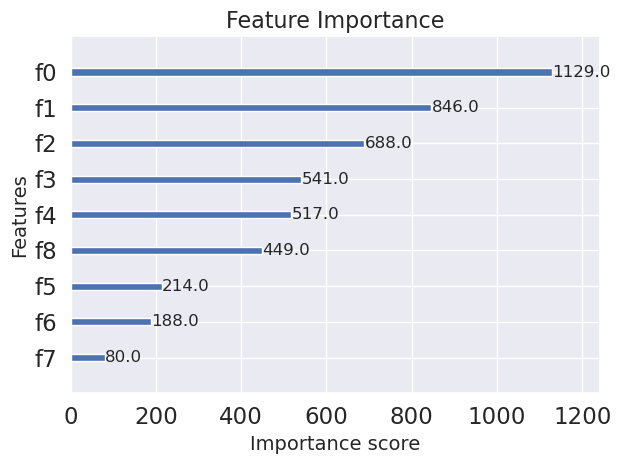

In [35]:
# 1. Feature Importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, importance_type='weight')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

               Date  Shown  Clicked  Converted  total_revenue  Ad_group  \
Date           1.00  -0.01     0.00      -0.01           0.01     -0.05   
Shown         -0.01   1.00    -0.03       0.01           0.01      0.01   
Clicked        0.00  -0.03     1.00      -0.01           0.00      0.02   
Converted     -0.01   0.01    -0.01       1.00           0.00      0.00   
total_revenue  0.01   0.01     0.00       0.00           1.00      0.03   
Ad_group      -0.05   0.01     0.02       0.00           0.03      1.00   
Region         0.02  -0.04     0.02       0.00          -0.06     -0.02   
Device_type    0.01  -0.01    -0.02       0.05          -0.02      0.00   
CTR            0.00  -0.48     0.87      -0.01           0.00      0.01   
ACPC          -0.01  -0.05     0.00       0.00          -0.04     -0.04   

               Region  Device_type   CTR  ACPC  
Date             0.02         0.01  0.00 -0.01  
Shown           -0.04        -0.01 -0.48 -0.05  
Clicked          0.02      

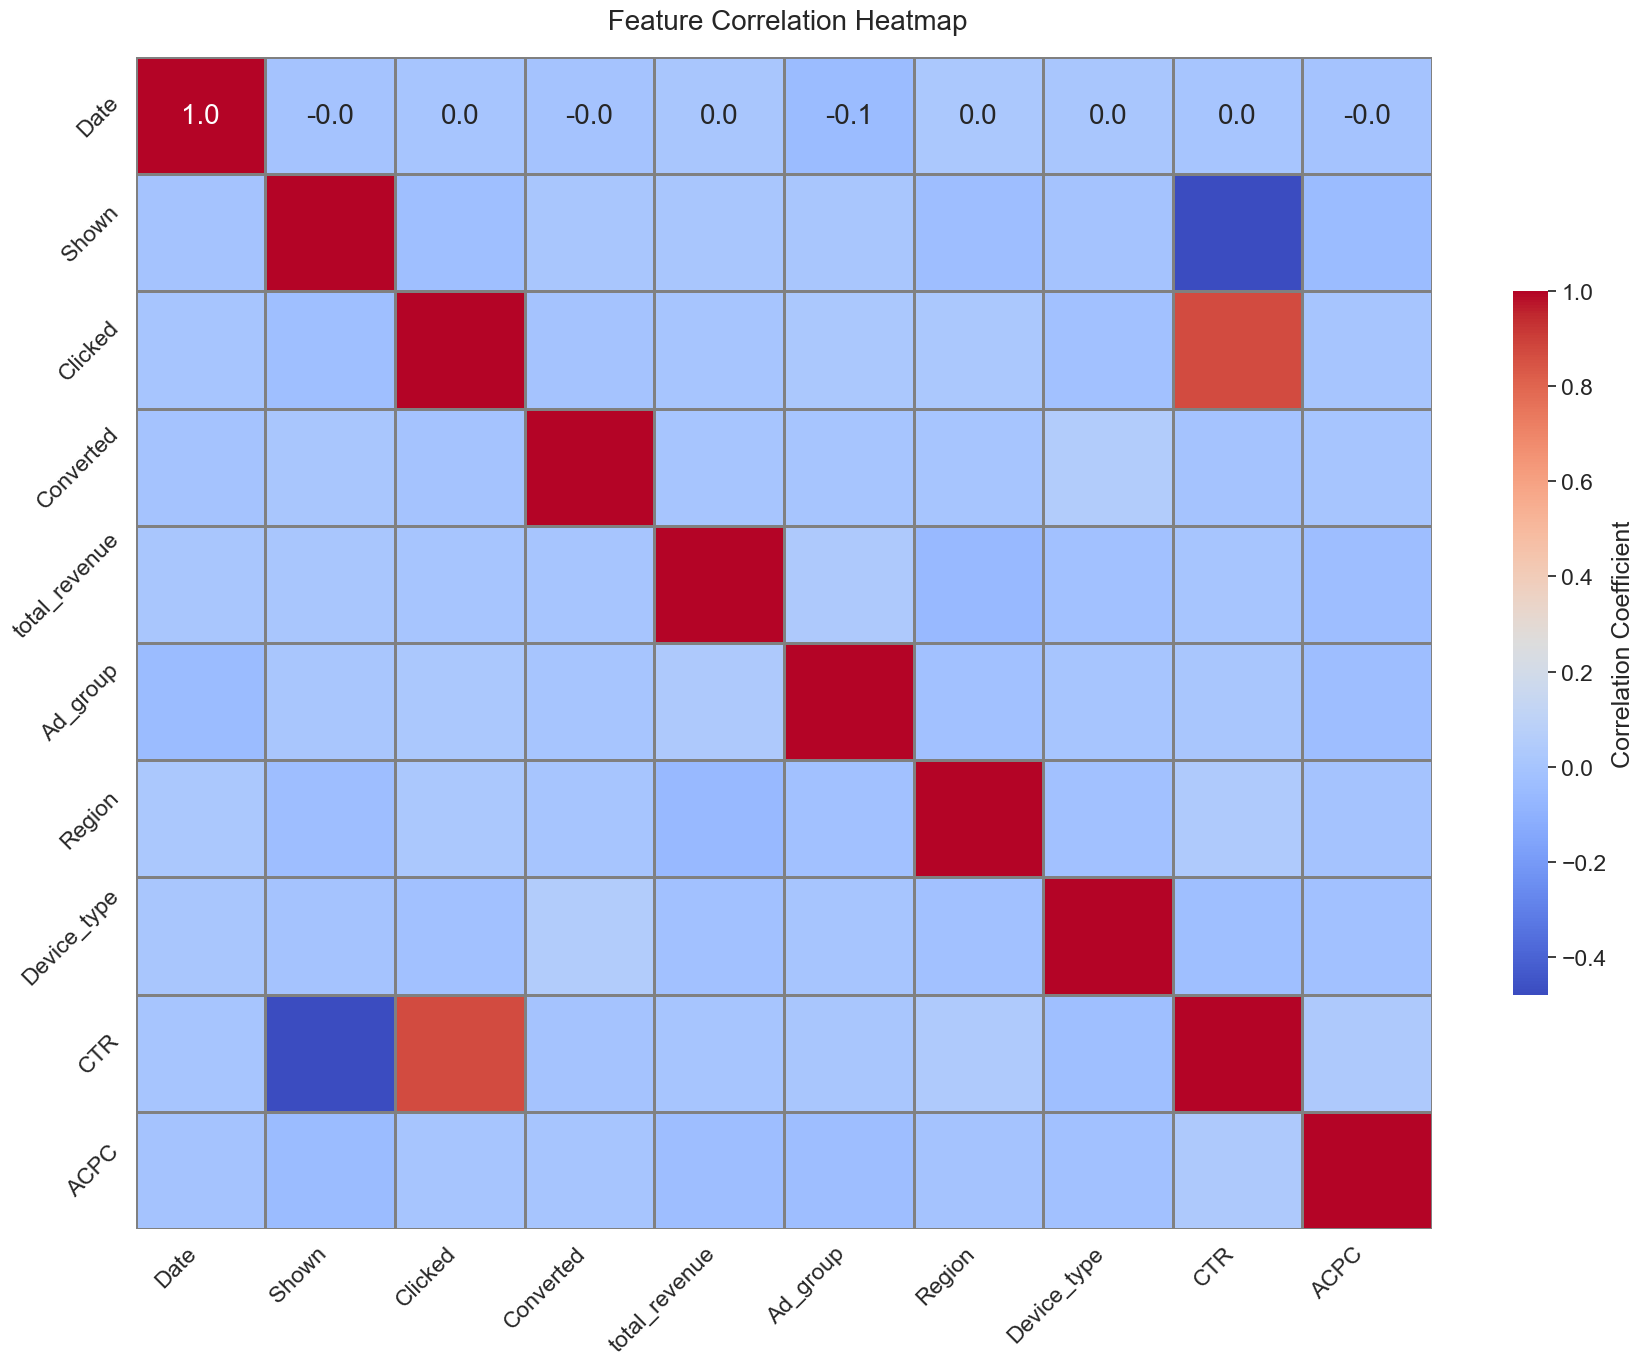

In [36]:
# 2. Heatmap with full annotations
data2 = data
data2['ACPC'] = data2['Avg_cost_per_click'] 
data2 = data2.drop('Avg_cost_per_click', axis=1)
plt.figure(figsize=(18, 14))
corr_matrix = data2.corr(numeric_only=True).round(2)
print(corr_matrix)

sns.set(font_scale=1.5)
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.9,
    linecolor='gray',
    annot_kws={"size": 20},
    cbar_kws={"shrink": 0.6, "label": "Correlation Coefficient"}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.title(" Feature Correlation Heatmap", fontsize=20, pad=20)
plt.tight_layout()
plt.show()

Columns available: ['Date', 'Shown', 'Clicked', 'Converted', 'Avg_cost_per_click', 'total_revenue', 'Ad_group', 'Region', 'Device_type', 'CTR', 'ACPC']


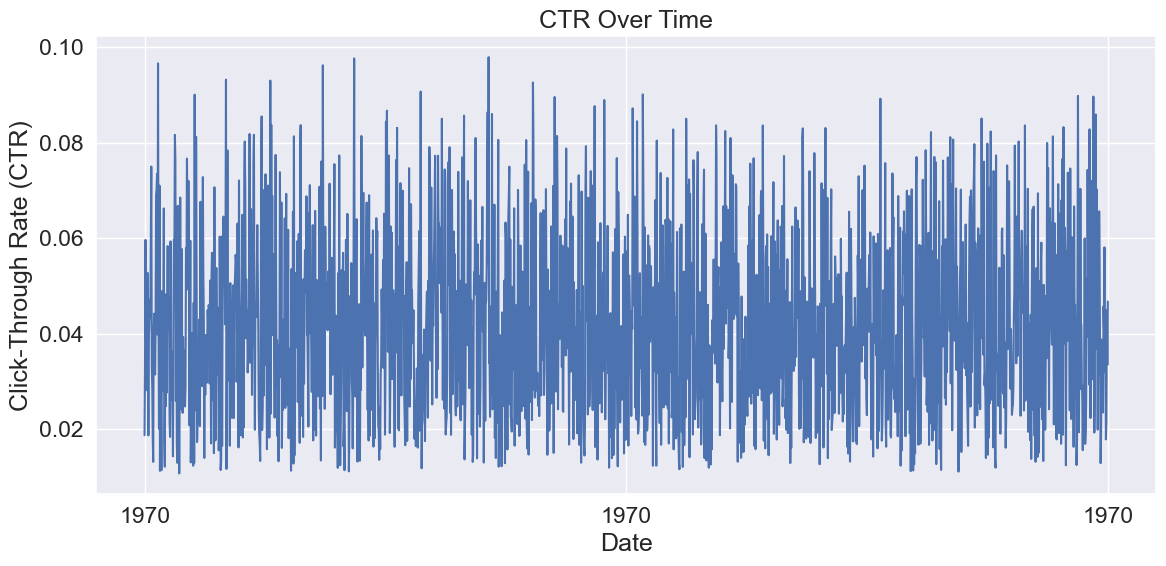

In [37]:
# 3. Plot CTR trend
# Check your actual column names
print("Columns available:", data.columns.tolist())

# 1. Create a 'date' column if you have year, month, day
if {'year', 'month', 'day'}.issubset(data.columns):
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
elif 'Date' in data.columns:
    data['date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
else:
    print("'year/month/day' or 'Date' column not found, cannot create 'date'.")

# 2. Calculate CTR safely
if 'Clicked' in data.columns and 'Shown' in data.columns:
    data['CTR'] = data['Clicked'] / data['Shown'].replace(0, np.nan)
else:
    print(" 'Clicked' or 'Shown' column missing, cannot compute CTR.")

# 3. Plot CTR trend
if 'CTR' in data.columns and 'date' in data.columns:
    data = data.sort_values('date')
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data, x='date', y='CTR')
    plt.title("CTR Over Time")
    plt.xlabel("Date")
    plt.ylabel("Click-Through Rate (CTR)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(" Cannot plot CTR trend — 'CTR' or 'date' column missing.")

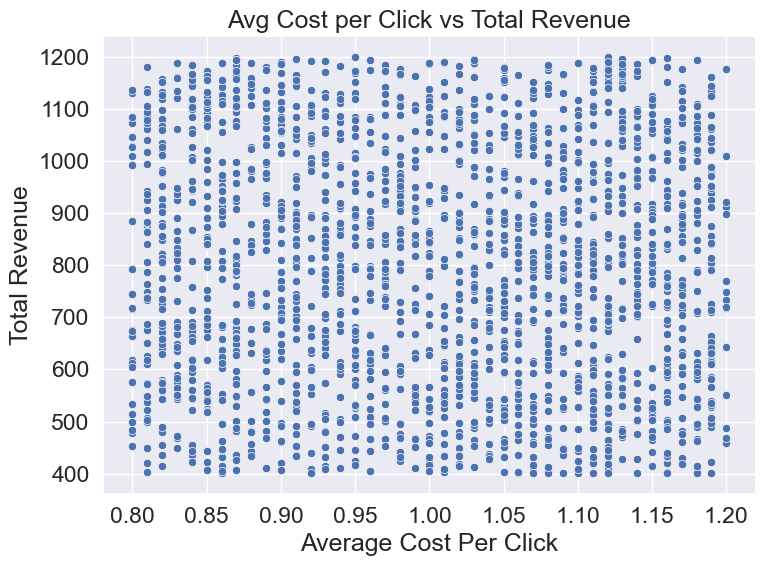

In [38]:
# 4. Plot Scatter: Avg cost per click vs total revenue
# Be sure to match case exactly (your column was 'Avg_cost_per_click')
# Now try plotting again
# 1. Standardize column names
data.columns = data.columns.str.strip().str.lower()

# 2. Now use lowercase names in your plot
if 'avg_cost_per_click' in data.columns and 'total_revenue' in data.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x='avg_cost_per_click', y='total_revenue')
    plt.title("Avg Cost per Click vs Total Revenue")
    plt.xlabel("Average Cost Per Click")
    plt.ylabel("Total Revenue")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(" Cannot plot scatter — 'avg_cost_per_click' or 'total_revenue' column missing.")


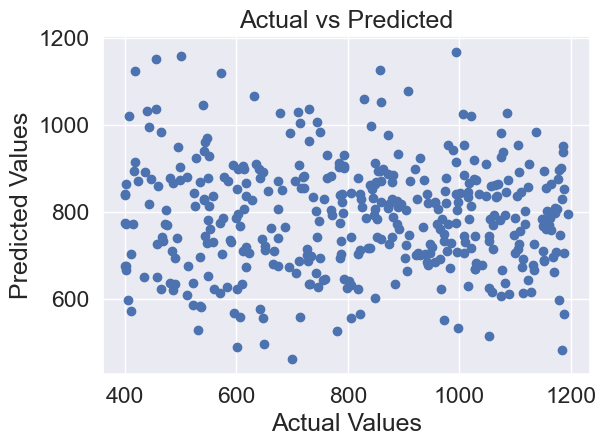

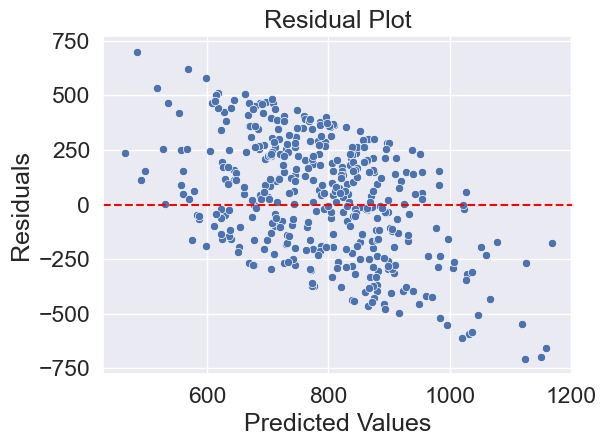

In [39]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()


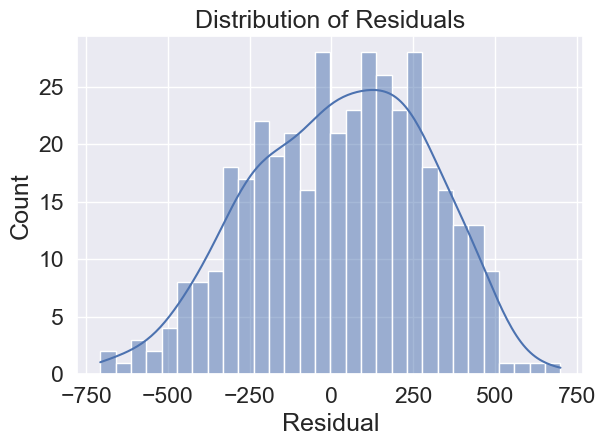

In [40]:
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()


In [43]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("synthetic_data.csv")  # Ensure correct file path

# Convert 'date' column
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], format="%d/%m/%Y", errors='coerce')
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data.drop('date', axis=1, inplace=True)

# Encode categorical features
for col in data.select_dtypes(include='object').columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Drop any missing values
data.dropna(inplace=True)

# Ensure target column name is consistent
if 'Total_revenue' in data.columns:
    data.rename(columns={'Total_revenue': 'total_revenue'}, inplace=True)

# Define features and target
X = data.drop(columns=['total_revenue'])
y = data['total_revenue']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Train model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("----- Total Revenue Prediction -----")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


----- Total Revenue Prediction -----
RMSE: 272.50
R² Score: -0.42


In [44]:
from sklearn.metrics import r2_score

# Predict
y_pred = model.predict(X_test)

# Calculate R² Score (acts like accuracy %)
r2 = r2_score(y_test, y_pred)

print(f"Accuracy: {r2 * 100:.2f} %")


Accuracy: -42.27 %
